In [1]:
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math
from sympy import Symbol, exp, sqrt, pi, Integral
from scipy.integrate import quad
from scipy.special import erf

import torch
import torch.utils.data as data
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda")

In [2]:
xx=[]
tx_snr = []
#H_f = 0.02515203629600967
#H_n = 0.40100521298869124
H_n=0.10025130324717278
H_f=0.04455613477652123
#H_f = 0.0402704167
#H_n = 0.367564136
#H_n = 0.3290121010789907
#H_f = 0.0395428085386695

snr = 60
for EbN0 in range(1,snr):
    #print([EbN0, H_f, H_n])
    xx.append([EbN0, H_f, H_n])
    tx_snr.append(math.pow(10,(EbN0/10)))
xx = torch.tensor(np.array(list(np.float_(xx)))).to(device)

In [3]:
m =nn.ReLU()
hidden = 8
class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        self.fc1 = nn.Linear(3,hidden)
        self.fc2 = nn.Linear(hidden,hidden)
        self.fc3 = nn.Linear(hidden,hidden)
        self.fc4 = nn.Linear(hidden,hidden)
        self.fc5 = nn.Linear(hidden,hidden)
        self.fc6 = nn.Linear(hidden,hidden)
        self.fc7 = nn.Linear(hidden,1)
    def forward(self, x):
        x = x.float()
        x = m(self.fc1(x))
        x = m(self.fc2(x))
        x = m(self.fc3(x))
        x = m(self.fc4(x))
        x = m(self.fc5(x))
        x = m(self.fc6(x))
        x = m(self.fc7(x))
        return x


In [4]:
model=mlp().to(device)

# loading_model = "./output/model_20210719.pth"
loading_model = "./output/model_20221121.pth"
model = torch.load(loading_model)
loss_fn = nn.MSELoss()

In [5]:
model.eval()
with torch.no_grad():
    output = model(xx).squeeze() #Different dimension may cause wrong results of backpropagation(Something called broadcasting)
#print(output/100)

In [6]:
def theory_f(tx_snr, H_f, p_n):
    return 0.25*(math.erfc(0.5*H_f*np.sqrt(tx_snr))+math.erfc((1-p_n-0.5)*H_f*np.sqrt(tx_snr)))

def theory_n(tx_snr, H_n, p_n):
    return 0.5*math.erfc(p_n*H_n/2*np.sqrt(tx_snr))

def theory_n_ip(tx_snr, H_n, p_n):
    x= Symbol('x')
    f = 1/sqrt(pi)*exp(-x**2)
    result = Integral(f,(x,H_n*(2*(1-p_n)- p_n)/2*sqrt(tx_snr),math.inf)) + Integral(f, (x, H_n*(p_n-2)/2*sqrt(tx_snr), -1/2*sqrt(tx_snr)*H_n))
    result = result.doit().evalf()/2
    result = (1-theory_f(tx_snr, H_n, p_n))*theory_n(tx_snr, H_n, p_n) + (theory_f(tx_snr, H_n, p_n) - result)
    return result

In [7]:
def FTPC(tx_snr, H_f, H_n, a):
    N0 = 1/np.log10(tx_snr)
    p_f = 1/((H_f/N0+H_n/N0)**(-a))*(H_f/N0)**(-a)
    p_n = 1/((H_f/N0+H_n/N0)**(-a))*(H_n/N0)**(-a)
    p_n = p_n/(p_f+p_n)
    return p_n

In [8]:
def qfunc(x):
    return 0.5-0.5*erf(x/np.sqrt(2))
def C(x):
    return np.log2(1+x)
def V(x):
    return (1-1/((1+x)**2))*np.log2(np.exp(1))**2
def n(x):
    t = 128
    err= 1e-5
    qe=qfunc(err)
    return np.sqrt((4*C(x)*qe**2*t+V(x)) + np.sqrt(V(x)))/(2*C(x)*qe)**2
def FBL(tx_snr, H_f, H_n):
    p_n =[]
    for i in range(1, 500):
        p_n.append(i/1000)
    N0 = 1/np.log10(tx_snr)
    t = np.zeros(500)
    for i in range(1,500):
        j = i-1
        sinr_n = (p_n[j]*H_n**2)/N0
        sinr_f = ((1-p_n[j])*H_f**2)/(p_n[j]*H_f**2+N0)
        
        #print(sinr_n, sinr_f)
        t[j]=n(sinr_n) + n(sinr_f)
    return p_n[np.argmin(t[0:499])]

In [9]:
proposed_F_BER = []
proposed_N_BER = []
proposed_NI_BER = []
proposed_avg_BER = []
fixed_F_BER = []
fixed_N_BER = []
fixed_NI_BER = []
fixed_avg_BER = []
fixed_avg_BER_03= []

FTPC_avg_BER = []
FBL_avg_BER = []
for i in range(1,snr):
    #print([EbN0, H_f, H_n])
    EbN0 = i-1
    p_n = output[EbN0]/100
    #proposed_F_BER.append(theory_f(tx_snr[EbN0], H_f, p_n))
    #proposed_N_BER.append(theory_n(tx_snr[EbN0], H_n, p_n))
    #proposed_NI_BER.append(theory_n_ip(tx_snr[EbN0], H_n, p_n))
    proposed_avg_BER.append((theory_n_ip(tx_snr[EbN0], H_n, p_n) + theory_f(tx_snr[EbN0], H_f, p_n))/2)
    
    p_n = 0.2
    #fixed_F_BER.append(theory_f(tx_snr[EbN0], H_f, p_n))
    #fixed_N_BER.append(theory_n(tx_snr[EbN0], H_n, p_n))
    #fixed_NI_BER.append(theory_n_ip(tx_snr[EbN0], H_n, p_n))
    fixed_avg_BER.append((theory_n_ip(tx_snr[EbN0], H_n, p_n) + theory_f(tx_snr[EbN0], H_f, p_n))/2)
    
    p_n= 0.3
    fixed_avg_BER_03.append((theory_n_ip(tx_snr[EbN0], H_n, p_n) + theory_f(tx_snr[EbN0], H_f, p_n))/2)
    
    p_n = FTPC(tx_snr[EbN0], H_f, H_n, a=0.4)
    FTPC_avg_BER.append((theory_n_ip(tx_snr[EbN0], H_n, p_n) + theory_f(tx_snr[EbN0], H_f, p_n))/2)
    
    p_n = FBL(tx_snr[EbN0], H_f, H_n)
    FBL_avg_BER.append((theory_n_ip(tx_snr[EbN0], H_n, p_n) + theory_f(tx_snr[EbN0], H_f, p_n))/2)
    

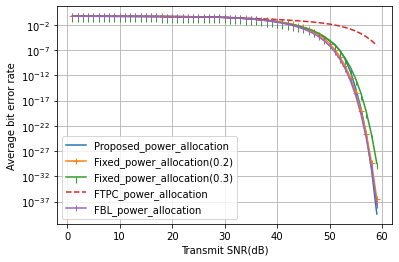

In [10]:
plt.figure()
#plt.plot(proposed_F_BER)
#plt.plot(proposed_N_BER)
#plt.plot(proposed_NI_BER)
EbN0 = range(1,snr)
plt.plot(EbN0, proposed_avg_BER)

#plt.plot(fixed_F_BER)
#plt.plot(fixed_N_BER)
#plt.plot(fixed_NI_BER)
plt.plot(EbN0, fixed_avg_BER,'-+')
plt.plot(EbN0, fixed_avg_BER_03, marker=3)

plt.plot(EbN0, FTPC_avg_BER, '--')

plt.plot(EbN0, FBL_avg_BER, '-|')

plt.legend(['Proposed_power_allocation','Fixed_power_allocation(0.2)','Fixed_power_allocation(0.3)','FTPC_power_allocation', 'FBL_power_allocation'])
#plt.legend(['Proposed_power_alloc(FU)' ,'Proposed_power_alloc(NU with perfect SIC)','Proposed_power_alloc(NU with imperfect SIC)','Proposed_power_alloc(average BER)', 'Fixed_power_alloc(FU)','Fixed_power_alloc(NU with perfect SIC)','Fixed_power_alloc(NU with imperfect SIC)','Fixed_power_alloc(average BER)'])
#plt.ylim((10^(-1), 10^(0)))

plt.xlabel('Transmit SNR(dB)') #(x 1000)')
plt.ylabel('Average bit error rate')
plt.semilogy()
plt.grid(True)
#plt.ylim(0,1000)
plt.show()
loss_temp = 0

In [11]:
for i in range(len(proposed_avg_BER)):
    print(proposed_avg_BER[i])

0.491405867577167
0.489937775151494
0.488339365177089
0.486560995956264
0.484937708093109
0.483118867078309
0.481082313618034
0.478818782203046
0.476298045347364
0.473477034960986
0.470319354604422
0.466848464496444
0.463028878494882
0.458770418640211
0.454138687775198
0.449033959083073
0.443508678873421
0.437646467900999
0.431230904528042
0.424298844869827
0.416974996391876
0.408975061212618
0.400227264150256
0.390231555039918
0.378682248489443
0.365108748454924
0.348934961329716
0.329886195197616
0.307998202331851
0.283594592058643
0.257297185695639
0.229829429862096
0.201426697203242
0.173878817579230
0.147207785221462
0.121169116617752
0.0982287581955654
0.0763080536295722
0.0583309336563791
0.0420291028026257
0.0284515512553239
0.0170169962462074
0.0100264169814837
0.00536289058459458
0.00251361705561647
0.00113836446414917
0.000420425451127374
0.000119971912166966
3.35565023559630e-5
6.53218019387261e-6
1.22569053774307e-6
7.69038243128380e-8
1.24280882151772e-9
4.78869887728053e

In [ ]:
for i in range(len(proposed_avg_BER)):
    print(fixed_avg_BER[i])

In [ ]:
for i in range(len(proposed_avg_BER)):
    print(fixed_avg_BER_03[i])

In [ ]:
for i in range(len(proposed_avg_BER)):
    print(FTPC_avg_BER[i])

In [ ]:
for i in range(len(proposed_avg_BER)):
    print(FBL_avg_BER[i])

In [ ]:
for i in range(len(tx_snr)):
    p_n = output[i]/100
    print('TX_SNR :', tx_snr[i])
    print('FU : ', theory_f(tx_snr[i], H_f, p_n))
    print('NU with PSIC : ', theory_n(tx_snr[i], H_n, p_n))
    print('NU with ISIC : ', theory_n_ip(tx_snr[i], H_n, p_n))